In [1]:
%pip install transformers datasets evaluate accelerate --quiet

Note: you may need to restart the kernel to use updated packages.


## RoBERTa Fine-Tune Task Overview: Political Stance Classification

This section fine-tunes the robust **RoBERTa-base** model for ternary stance classification using the preprocessed JSONL files.  Hi

### 1. Load Data, Map Labels, and Prepare Target
* **Source Files:** Reads the pre-split files from `/kaggle/input/pstance/` (specifically `train.jsonl`, `val.jsonl`, and `test.jsonl`).
* **Label Mapping:** The string `stance` labels (`FAVOR`, `AGAINST`, `NONE`) are mapped to the required **integer `labels`** (`0`, `1`, `2`) column for the model to compute loss.
* **Input Text:** The input text for the model is either the single `tweet` column or a concatenation of the `target` (candidate name) and the `tweet` text (`target [SEP] tweet`), depending on the existence of the `target` column in the JSONL files.

### 2. Create Hugging Face Datasets and Tokenize
* **Conversion:** Converts the prepared pandas DataFrames (`train_df`, `val_df`, `test_df`) into Hugging Face `Dataset` objects.
* **Tokenization:** Tokenizes the input text using the `roberta-base` tokenizer, applying truncation to sequence length limits.
* **Cleanup:** Removes all unnecessary columns (like the original `stance` and `tweet` columns), keeping only the required model inputs: `input_ids`, `attention_mask`, and the final integer `labels`.

### 3. Configure Model and Training Arguments
* **Model Loading:** Instantiates `AutoModelForSequenceClassification` using the "roberta-base" checkpoint, setting `num_labels=3` for ternary classification.
* **Hardware Scaling:** Training and evaluation batch sizes are dynamically adjusted (16/32 on GPU, 4/8 on CPU) for optimal use of Kaggle's available hardware.
* **Loss Optimization:** Sets a small `learning_rate` (`2e-5`) and `weight_decay` (`0.01`), which are standard practices for fine-tuning transformers.

### 4. Train with Early Stopping
* **Strategy:** Uses the Hugging Face `Trainer` class to fine-tune the model for `num_train_epochs=3`.
* **Monitoring:** The model's performance is logged, saved, and evaluated every `500` steps (`eval_steps=500`).
* **Best Model Selection:** Uses **Early Stopping** logic by setting `load_best_model_at_end=True` based on the **`eval_f1`** (Macro F1-Score). This ensures the final model uses the weights that achieved the best generalization performance on the validation set.

### 5. Evaluate and Measure
* **Evaluation Metric:** The custom `compute_metrics` function calculates **Accuracy** and **Macro F1-Score** on the validation set.
* **Macro F1-Score:** This is the primary metric, as it calculates the F1-score for each of the three stance classes (`favor`, `against`, `none`) independently before averaging them. This is key for ensuring the model performs well on all categories, even if the number of instances for `FAVOR` or `AGAINST` is imbalanced compared to `NONE`.

In [2]:
import pandas as pd
import numpy as np
import os
import ssl
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import evaluate
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set SSL/HF environment variables
os.environ["HF_HUB_DISABLE_SSL_VERIFICATION"] = "1"
os.environ["CURL_CA_BUNDLE"] = ""
os.environ["SSL_CERT_FILE"] = ""
os.environ["REQUESTS_CA_BUNDLE"] = ""

ssl._create_default_https_context = ssl._create_unverified_context

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base", trust_remote_code=True)

2025-12-15 20:06:04.418496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765829164.440073     240 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765829164.446758     240 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# (Optional) Subset for smoke test
# Uncomment the following lines to use a smaller subset for quick debugging
#train_df = train_df.sample(n=1000, random_state=42)
#val_df = val_df.sample(n=200, random_state=42)
#test_df = test_df.sample(n=200, random_state=42)
#print(f"Subset sizes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

In [ ]:
df = pd.read_csv("/kaggle/input/pstance/cleaned_pstance.csv")
df.head()

,text,Stance,clean_tweet,clean_target
0,"i endorse bernie for tons of reasons, but this...",FAVOR,"i endorse bernie for tons of reasons, but this...",bernie sanders
1,a big problem wbernie left is not only preoccu...,AGAINST,a big problem wbernie left is not only preoccu...,bernie sanders
2,this poll is not reflecting anything: age was ...,AGAINST,this poll is not reflecting anything: age was ...,bernie sanders
3,so proud how is shedding light on who is truly...,FAVOR,so proud how is shedding light on who is truly...,bernie sanders
4,"according to media bias fact checker, you have...",FAVOR,"according to media bias fact checker, you have...",bernie sanders


In [5]:
train_df = pd.read_json("/kaggle/input/pstance/train.jsonl", lines=True)
val_df   = pd.read_json("/kaggle/input/pstance/val.jsonl",   lines=True)
test_df  = pd.read_json("/kaggle/input/pstance/test.jsonl",  lines=True)

# Define a mapping from string stances to integer labels
# This maps 'FAVOR' to 0 and 'AGAINST' to 1, aligning with a num_labels=2 model or the logic of your 'compute_metrics'
# If your classification is only binary (FAVOR vs. AGAINST), you should use num_labels=2 in your model definition.
# If you are doing ternary (FAVOR, AGAINST, NONE), make sure NONE is handled. 

# ASSUMING YOUR MODEL IS BINARY (FAVOR/AGAINST) FOR NOW, based on typical RoBERTa fine-tuning
# If you are using num_labels=3, see the note below this code block!
dataset_label_map = {
    'FAVOR': 0,
    'AGAINST': 1,
    'NONE': 2 # Assign -1 to NONE if you want to drop or ignore it for binary classification
}

# Apply the mapping to create the 'labels' column
train_df['labels'] = train_df['stance'].map(dataset_label_map)
val_df['labels'] = val_df['stance'].map(dataset_label_map)
# Note: You should check if you need labels for the test set or if you are just predicting.
test_df['labels'] = test_df['stance'].map(dataset_label_map) 

# Drop any rows where the 'stance' was not mapped (e.g., 'NONE' if mapping to -1)
train_df.dropna(subset=['labels'], inplace=True)
val_df.dropna(subset=['labels'], inplace=True)
test_df.dropna(subset=['labels'], inplace=True) 

# Convert the float label column to the required integer type
train_df['labels'] = train_df['labels'].astype(int)
val_df['labels'] = val_df['labels'].astype(int)
test_df['labels'] = test_df['labels'].astype(int)

print("DataFrames loaded, 'labels' column created, and rows with unmapped stances dropped.")

DataFrames loaded, 'labels' column created, and rows with unmapped stances dropped.


In [6]:
# 3) Configure model and training args (smaller batches/epochs)
import torch
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments

has_cuda = torch.cuda.is_available()
train_bs = 4 if not has_cuda else 16
eval_bs = 8 if not has_cuda else 32

MODEL_NAME = "roberta-base" # Define MODEL_NAME
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
collator = DataCollatorWithPadding(tokenizer)

OUTPUT_DIR = "./model_output"

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)
# The 'cols_to_keep' line is no longer necessary here.

print("Hugging Face Datasets created from the labeled DataFrames.")

Hugging Face Datasets created from the labeled DataFrames.


In [8]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Detect text column
if "text" in train_df.columns:
    text_col = "text"
elif "tweet" in train_df.columns:
    text_col = "tweet"
else:
    candidates = [c for c in train_df.columns if c not in ["labels", "stance"]]
    text_col = candidates[0]

use_target = "target" in train_df.columns

def tokenize_function(batch):
    if use_target:
        texts = [f"{tgt} [SEP] {txt}" for tgt, txt in zip(batch["target"], batch[text_col])]
    else:
        texts = batch[text_col]
    return tokenizer(texts, truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
valid_ds = valid_ds.map(tokenize_function, batched=True)
test_ds  = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/15101 [00:00<?, ? examples/s]

Map:   0%|          | 0/3236 [00:00<?, ? examples/s]

Map:   0%|          | 0/3237 [00:00<?, ? examples/s]

In [9]:
# Keep needed columns
cols_to_keep = ["input_ids", "attention_mask", "labels"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols_to_keep])
valid_ds = valid_ds.remove_columns([c for c in valid_ds.column_names if c not in cols_to_keep])
test_ds  = test_ds.remove_columns([c for c in test_ds.column_names if c not in cols_to_keep])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0: "favor", 1: "against", 2: "none"},
    label2id={"favor": 0, "against": 1, "none": 2},
)

# --- FIX: Map 'stance' column to integer 'labels' ---
# Verify unique stances in the dataframes
print("Unique stances in train_df:", train_df['stance'].unique())
print("Unique stances in val_df:", val_df['stance'].unique())
print("Unique stances in test_df:", test_df['stance'].unique())

# Define a mapping from string stances (from JSONL files) to integer labels
# Assuming the 'stance' column contains 'FAVOR' and 'AGAINST' (uppercase)
# This mapping aligns with the model's id2label: 0 for 'favor', 1 for 'against'
dataset_label_map = {
    'FAVOR': 0,    # Map 'FAVOR' from data to integer label 0
    'AGAINST': 1,  # Map 'AGAINST' from data to integer label 1
    'NONE': 2      # Include 'NONE' if it exists in data, otherwise it will be unassigned
}

# Apply the mapping to create the 'labels' column
train_df['labels'] = train_df['stance'].map(dataset_label_map)
val_df['labels'] = val_df['stance'].map(dataset_label_map)
test_df['labels'] = test_df['stance'].map(dataset_label_map)

# Check for any unmapped stances (NaNs) and print a warning if found
if train_df['labels'].isnull().any():
    print("Warning: Unmapped stance values in train_df after mapping to labels:", train_df[train_df['labels'].isnull()]['stance'].unique())
if val_df['labels'].isnull().any():
    print("Warning: Unmapped stance values in val_df after mapping to labels:", val_df[val_df['labels'].isnull()]['stance'].unique())
if test_df['labels'].isnull().any():
    print("Warning: Unmapped stance values in test_df after mapping to labels:", test_df[test_df['labels'].isnull()]['stance'].unique())
# --- END FIX ---

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unique stances in train_df: ['FAVOR' 'AGAINST']
Unique stances in val_df: ['FAVOR' 'AGAINST']
Unique stances in test_df: ['FAVOR' 'AGAINST']


In [11]:
training_args = TrainingArguments(
    output_dir="./roberta_results",

    do_train=True,
    do_eval=True,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    num_train_epochs=3,
    weight_decay=0.01,

    # NEW TRANSFORMERS API (4.57.3)
    eval_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",

    logging_steps=100,
    save_steps=500,
    eval_steps=500,

    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",

    report_to="none"
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

/tmp/ipykernel_240/31267686.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.548700,0.535560,0.746292,0.740943
1000,0.442800,0.489114,0.776576,0.775921
1500,0.391100,0.546763,0.787701,0.787363
2000,0.325100,0.555537,0.793572,0.792797
2500,0.315300,0.536805,0.797590,0.796571


TrainOutput(global_step=2832, training_loss=0.41997230995846335, metrics={'train_runtime': 457.973, 'train_samples_per_second': 98.921, 'train_steps_per_second': 6.184, 'total_flos': 1745986723079004.0, 'train_loss': 0.41997230995846335, 'epoch': 3.0})

Test results: {'eval_loss': 0.5156769752502441, 'eval_accuracy': 0.8010503552672228, 'eval_f1': 0.7998080118742235, 'eval_runtime': 7.8606, 'eval_samples_per_second': 411.8, 'eval_steps_per_second': 25.825, 'epoch': 3.0}


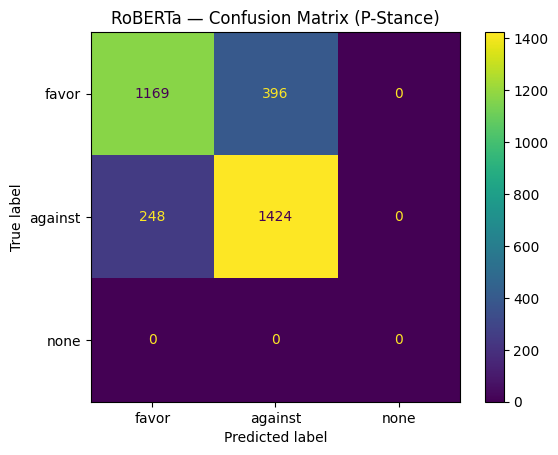

In [13]:
test_results = trainer.evaluate(test_ds)
print("Test results:", test_results)
preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=["favor","against","none"])
disp.plot(values_format="d")
plt.title("RoBERTa — Confusion Matrix (P-Stance)")
plt.show()

In [14]:
# RUN THIS ONLY ONE TIME
pred_output = trainer.predict(test_ds)
np.save("y_true.npy", pred_output.label_ids)
np.save("y_pred.npy", np.argmax(pred_output.predictions, axis=1))
print("Saved predictions.")

Saved predictions.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Convert predictions
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

# ============================
# CLASSIFICATION REPORT VISUAL
# ============================

report = classification_report(
    y_true,
    y_pred,
    labels=[0,1,2],
    target_names=["favor","against","none"],
    output_dict=True,
    zero_division=0
)

classes = ["favor","against","none"]
f1_scores = [report[c]["f1-score"] for c in classes]
precision = [report[c]["precision"] for c in classes]
recall = [report[c]["recall"] for c in classes]

print("F1 scores:", f1_scores)
print("Precision:", precision)
print("Recall:", recall)
print("Classification report:\n", classification_report(
    y_true, y_pred, labels=[0,1,2], target_names=["favor","against","none"], zero_division=0
))

F1 scores: [0.784037558685446, 0.815578465063001, 0.0]
Precision: [0.8249823570924488, 0.7824175824175824, 0.0]
Recall: [0.746964856230032, 0.8516746411483254, 0.0]
Classification report:
               precision    recall  f1-score   support

       favor       0.82      0.75      0.78      1565
     against       0.78      0.85      0.82      1672
        none       0.00      0.00      0.00         0

   micro avg       0.80      0.80      0.80      3237
   macro avg       0.54      0.53      0.53      3237
weighted avg       0.80      0.80      0.80      3237

